# Regularizing Tree-Based Models


In this demo we're going to use a Decision Tree and then take a look at its various hyperparameters and how they affect the bias-variance trade-off and how we can regularize the tree by tweaking them. We're gonna be using the same set of features and targets we used in our last demo on k-NNs. But the regression model was really struggling coz we would've needed much more informative features and many more of them for it to learn anything meaningful. This time we'll just focus on classification but do keep in mind that there is a DecisionTreeRegressor as well, should you want to use it.


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

So again the target is the direction of 1-day returns and we'll use the same features we engineered before.


In [38]:
data = pd.read_csv("AAPL.csv")
data.head()

,Open,High,Low,Close,Adj Close,Volume,Date,1d_Prev_Adj_Close,1d_Lagged_Return,5d_Prev_Adj_Close,5d_Lagged_Return,20d_Prev_Adj_Close,20d_Lagged_Return,RSI,1d_Future_Adj_Close,1d_Future_Return,1d_Future_Return_Positive
0,0.401071,0.407321,0.394286,0.398571,0.336583,287431200,2004-02-02,0.340203,-0.010639,0.346989,-0.029989,0.320901,0.048871,34.228229,0.335679,-0.002687,0
1,0.398214,0.400000,0.392857,0.397500,0.335679,180812800,2004-02-03,0.336583,-0.002687,0.347894,-0.035110,0.334322,0.004059,27.536956,0.328591,-0.021114,0
2,0.392857,0.394464,0.387500,0.389107,0.328591,305552800,2004-02-04,0.335679,-0.021114,0.339600,-0.032416,0.333115,-0.013580,23.399907,0.338092,0.028912,1
3,0.389643,0.409107,0.389464,0.400357,0.338092,352844800,2004-02-05,0.328591,0.028912,0.342013,-0.011464,0.340655,-0.007526,44.356761,0.342465,0.012936,1
4,0.400893,0.408750,0.400000,0.405536,0.342465,193340000,2004-02-06,0.338092,0.012936,0.340203,0.006650,0.352267,-0.027825,49.874431,0.341861,-0.001763,0


And specify our feature and target columns.


In [39]:
X = data[["1d_Lagged_Return", "5d_Lagged_Return", "20d_Lagged_Return", "RSI"]]
y = data["1d_Future_Return_Positive"]

Split the data into training and test sets again 80-20...


In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4009, 4), (1003, 4), (4009,), (1003,))

For tree-based models we actually do not need to scale the features because they don't work based on distances. So we can leave the features as-is. I'm going to train a basic DecisionTreeClassifier now with its default hyperparameter values.


In [41]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

And now we inspect its cross-validation score, test score and learning curves...


In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1)
mean_cv_score = np.mean(cv_scores)
print(f"Cross-Validated Accuracy: {mean_cv_score:.4f}")

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

Cross-Validated Accuracy: 0.4939
Test Accuracy: 0.4965


So regardless of how good this test score actually is compared to a naive strategy like guessing randomly or buy-and-hold, let's focus on just overfitting and underfitting. We can look at learning curves or we can even just start by looking at the accuracy on the training set. Let's do the latter first...

In [43]:
# Accruacy score on the training set
train_acc = clf.score(X_train, y_train)
print(f"Train Accuracy: {train_acc:.4f}")

Train Accuracy: 1.0000


The model has a **PERFECT** accuracy score, despite reaching an accuracy of just around 50% on validation and test sets. This is a classic and extreme example of overfitting. Of course we can see the same things with the learning curves:

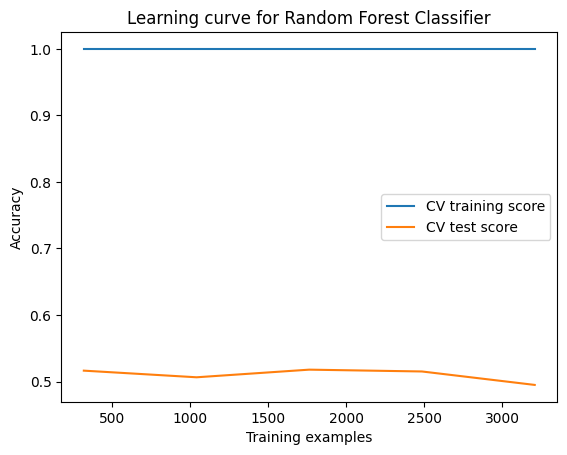

In [44]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, cv=5, n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, label="CV training score")
    plt.plot(train_sizes, test_scores_mean, label="CV test score")
    plt.title("Learning curve for Random Forest Classifier")
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_learning_curve(clf, X_train, y_train)

It was overfitting even using 10% of the data. This is actually not surprising at all. Because when we allow a decision tree to reach its maximum depth, it will always overfit. Why? Because it's unconstrained and will keep branching more and more until it's memorized every single training example's features. At the extreme, that is, in the leaf nodes, you essentially have decision nodes that effectively say for this specific combination of values for these features, predict 1 or 0! And that's no good, right? Let's see what we can do about that.  

There are two ways to mitigate this. One is using ensemble methods like Random Forests which are super handy and you'll see them elsewhere in the course. But right now let's focus on the more basic and arguably more important method: pruning. Pruning is exactly what it sounds like. We prune the tree to prevent it from getting too large, and we do this by constraining its hyperparameters.  

Let's visualize the un-pruned tree to get a sense of how Decision Trees work first.

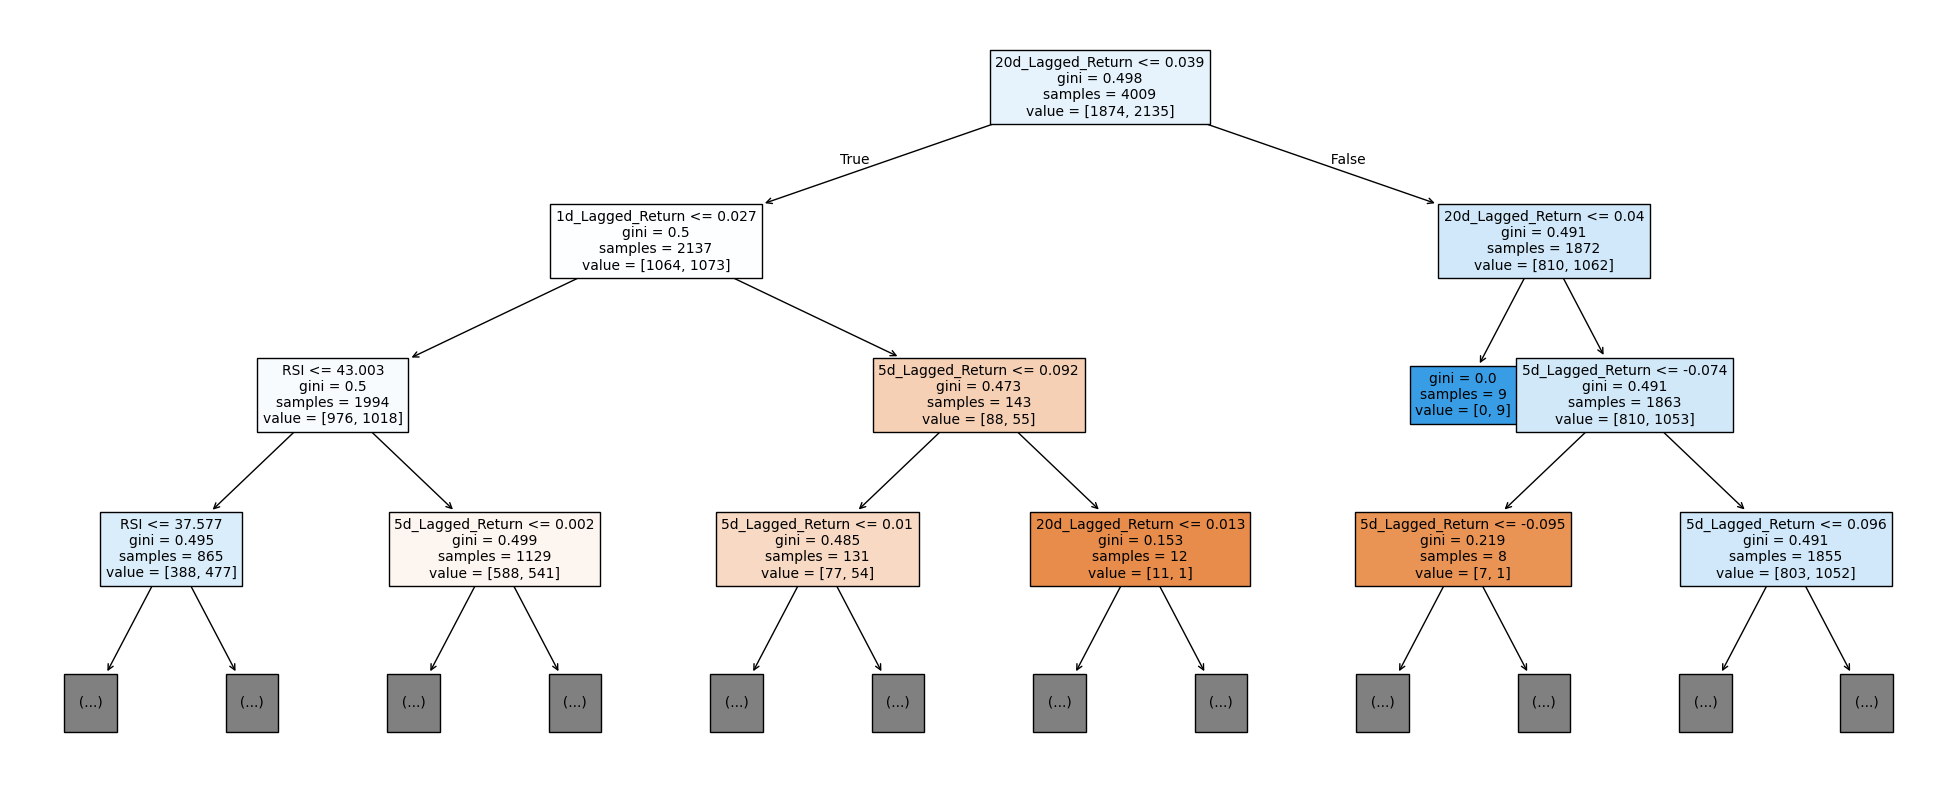

In [45]:
from sklearn.tree import plot_tree

plt.figure(figsize=(25, 10))
plot_tree(clf, feature_names=X.columns, filled=True, fontsize=10, max_depth=3)
plt.show();

# Orange = 0, Blue = 1; darker shade means lower gini impurity;

In [46]:
from sklearn.tree import export_text

# text_representation = export_text(clf, feature_names=X.columns, max_depth=100, decimals=3, show_weights=True)

text_representation = export_text(clf, feature_names=X.columns, max_depth=100, decimals=3)
print(text_representation)

|--- 20d_Lagged_Return <= 0.039
|   |--- 1d_Lagged_Return <= 0.027
|   |   |--- RSI <= 43.003
|   |   |   |--- RSI <= 37.577
|   |   |   |   |--- 5d_Lagged_Return <= -0.095
|   |   |   |   |   |--- 5d_Lagged_Return <= -0.110
|   |   |   |   |   |   |--- RSI <= 18.333
|   |   |   |   |   |   |   |--- RSI <= 6.700
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- RSI >  6.700
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- RSI >  18.333
|   |   |   |   |   |   |   |--- RSI <= 36.395
|   |   |   |   |   |   |   |   |--- 1d_Lagged_Return <= -0.076
|   |   |   |   |   |   |   |   |   |--- 20d_Lagged_Return <= -0.257
|   |   |   |   |   |   |   |   |   |   |--- 5d_Lagged_Return <= -0.228
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- 5d_Lagged_Return >  -0.228
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- 20d_Lagged_Return >  -0.

And now let's see what we can do to prune this tree. The most obvious thing to do is to restrict its maximum depth so let's start with that.

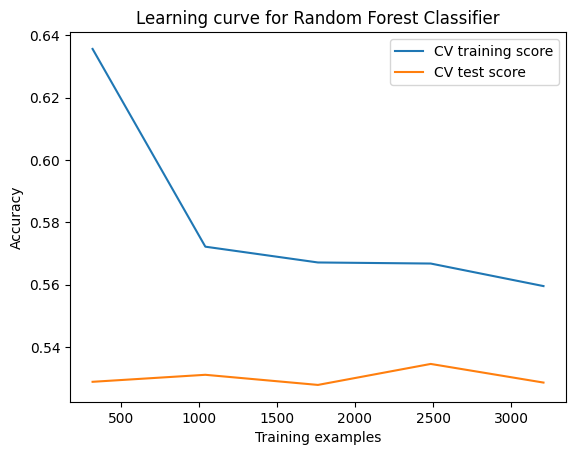

Test Accuracy: 0.5115


In [47]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
plot_learning_curve(clf, X_train, y_train)
y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

And just like that we've improved overfitting by leaps and bounds. Now again as before our features aren't too informative so the CV and test scores haven't budged much but we do see an improvement. We can actually say the model is underfitting now because the training and test scores are **BOTH** low. The point is to demonstrate the effect pruning can have in principle, which we can clearly see in the reduced variance, although it is in the extreme right now. There's no way we can capture all the nuance with a three-level tree... Let's _visualize_ this tree now, and since it only has a maximum depth of 3 we can actually see the whole thing:

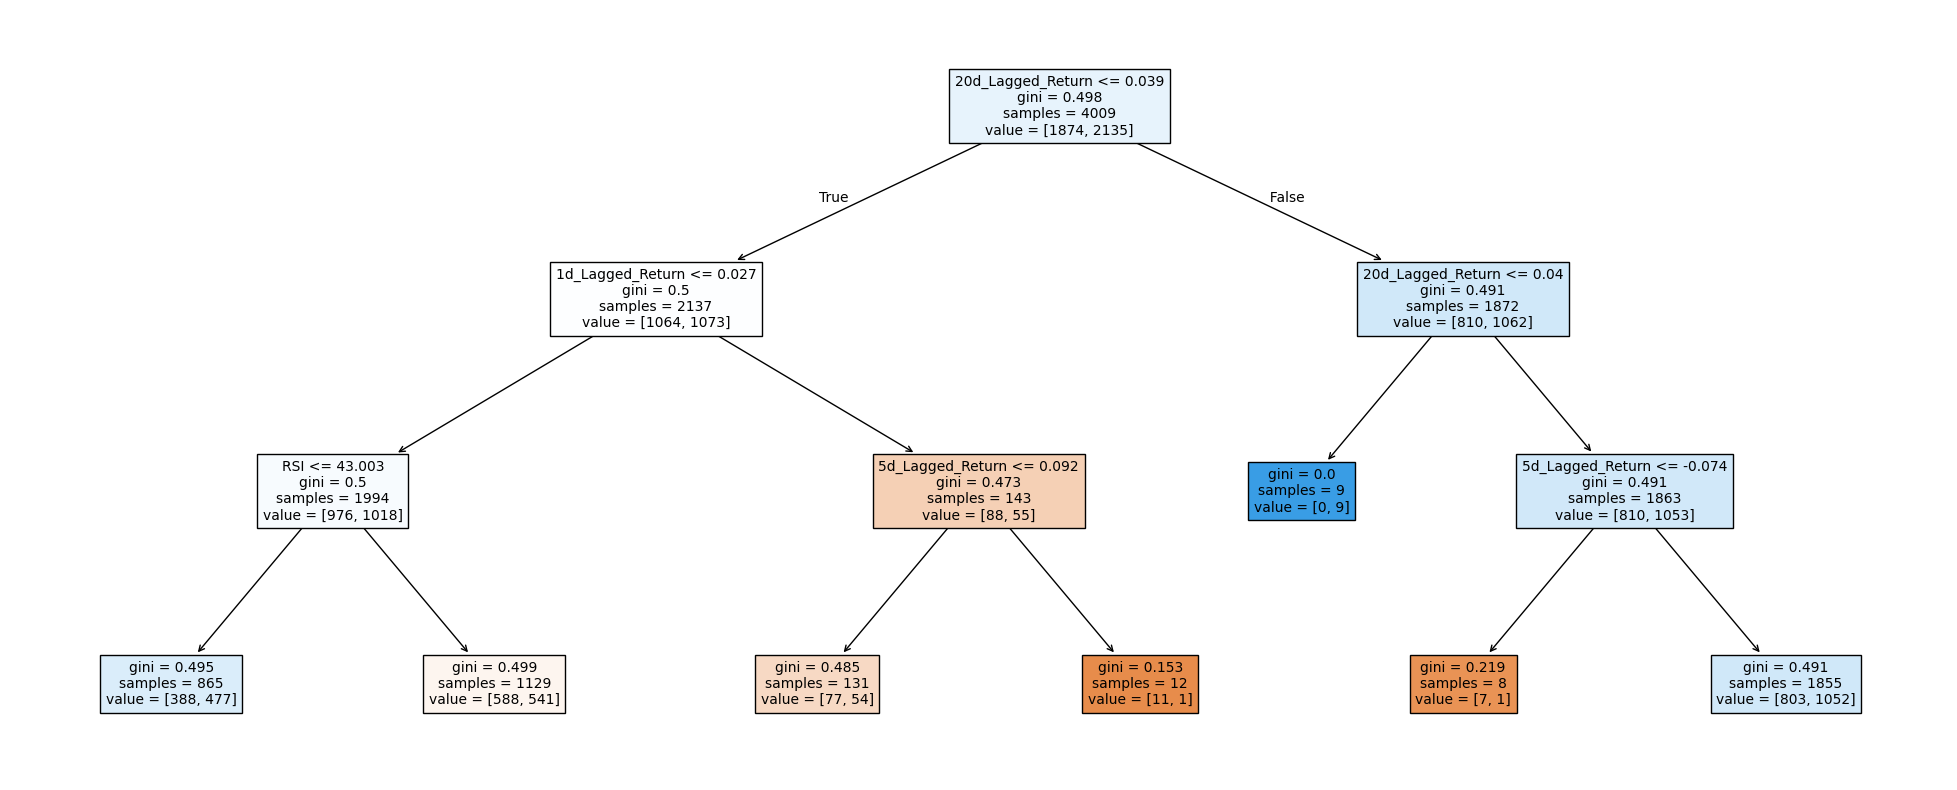

In [48]:
plt.figure(figsize=(25, 10))
plot_tree(clf, feature_names=X.columns, filled=True, fontsize=10, max_depth=3)
plt.show();

And there are other ways to prune the tree, for example by setting a higher minumum number of samples required to be present in a leaf node, which would address situations like this dark blue node here and create larger pools in the leaf nodes; or by increasing the minimum number of samples required in a decision node before making a split (the ones in the middle of the tree) which would force the model to make fewer splits. I hope you'll attempt the exercises where you'll experiment with some of these other hyperparameters and see their effect in practice. Good luck!